In [146]:
import networkx as nx
import matplotlib.pyplot as plt
import pprint
from pprint import pprint as pprint
import collections
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.schema import Table, DropTable
import pandas as pd

In [128]:
G = nx.Graph()

In [129]:
Session = sessionmaker()
engine = create_engine('sqlite:///twitter.db')

In [130]:
users = pd.read_sql_query('SELECT user1.user_name AS user, COUNT(*) as number_of_retweets, \
                            user2.user_name AS retwitter \
                            FROM user AS user1 \
                             JOIN tweet ON tweet.user_id = user1.user_id \
                             JOIN retweet ON retweet.source_tweet_id = tweet.tweet_id \
                             JOIN user AS user2 ON retweet.user_id = user2.user_id \
                             GROUP BY user, retwitter', engine)
print(users)

                                          user  number_of_retweets  \
0                                         None                   1   
1                            "We the People" 🏁                   1   
2       #Bangladesh News 24 (#BreakingNews 24)                   1   
3       #Bangladesh News 24 (#BreakingNews 24)                   1   
4                                     #BearJew                   1   
5                           #BlueWave Thoughts                   1   
6                           #BlueWave Thoughts                   1   
7                           #BlueWave Thoughts                   1   
8                           #BlueWave Thoughts                   1   
9                           #BlueWave Thoughts                   1   
10                    #BobsTerLove #ArmyOfLove                   1   
11                           #Deplorable Sunny                   1   
12                           #Deplorable Sunny                   1   
13                  

In [139]:
G = nx.from_pandas_edgelist(users, 'retwitter', 'user', 'number_of_retweets')

In [151]:
# Get nodes with degree >= min_degree

min_degree = 15

nodes = [node for node, degree in G.degree() if degree >= min_degree]

In [152]:

# Create a subgraph with nodes degree >= min_degree (in the G graph)

G_sampled = G.subgraph(nodes)
pprint(nx.info(G_sampled))


('Name: \n'
 'Type: Graph\n'
 'Number of nodes: 1011\n'
 'Number of edges: 9136\n'
 'Average degree:  18.0732')


In [153]:
def get_histogram(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

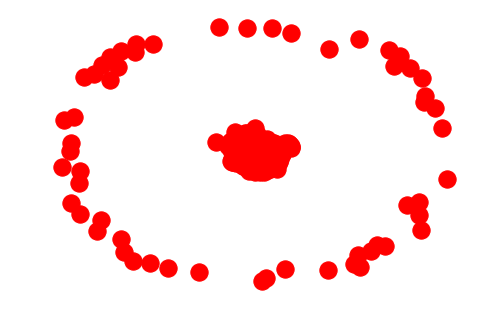

In [154]:
nx.draw(G_sampled, with_labels=False, edges=G_sampled.edges)
plt.show()

In [155]:
print("users", len(G_sampled.nodes))
print("connections",len(G_sampled.edges))

users 1011
connections 9136


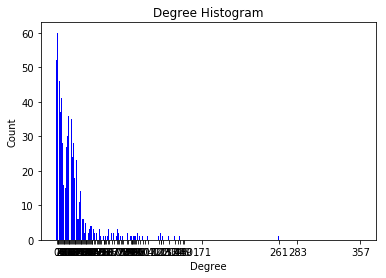

In [156]:
# avg_node_connectivity = nx.networkx.average_node_connectivity(G)
# print('Average node connectivity: ', avg_node_connectivity)

get_histogram(G_sampled)

In [157]:
from networkx.algorithms.community.centrality import girvan_newman
communities_iter = girvan_newman(G_sampled)

communities_sum = 0
communities_gn = []

for community_gn in next(communities_iter):
    communities_sum += 1
    communities_gn.append(community_gn)
    print("Community ", communities_sum)
    print(community_gn)
    print("Liczność community: ", len(community_gn), "\n")
    
print("Znaleziono communities: ", communities_sum)

Community  1
{'Beth אמא ציונית', 'John~💋Kiss My Bot', 'Jill 🇺🇸', 'Deplorable Linda G. {⭐}', 'Greg', 'Lana', '∂(Megan)/∂(t)🇺🇸', 'Sheriff Paul Babeu', 'Bossy Brat', 'Dorcas↩', 'Leigh', 'Wrath of Khan', 'Deplorable FOR TRUMP', 'Sarah Ruth Ashcraft', 'Azadeh Shahshahani', 'Bry0 🇺🇸 VOTED RED Nationalist for USA', 'LydiaL', 'Margrit', 'james cabbage', 'Oak-town ☢ Unfiltered / Vote Republican', 'DeplorableRN⭐️⭐️⭐️', 'Max 🥀🦋🌿🇺🇸', 'Becca Kroll', 'Allen West', 'IowaPatriot', 'sofie 💋👠🇺🇸🙏🏼', 'Kathy', 'flgrammie', 'LOVEUSATRUMP', 'Tim Donnelly for Congress', 'Tommy', 'The Tweetwit', 'buildingbetterlives ❌', 'Deb Richie 🇺🇸', '⭐️♦️NationalistMare♦️⭐️VOTE RON DESANTIS', '👠Anita  🔴VOTERED 🔴', 'Laurie Williams ❌ ⭐️⭐️⭐️', 'Jamie Ford', 'Alisha VOTED💃🏽🌊', 'Matty Enders #MAGA Veteran', '🇺🇸BJ💙', 'Rick Baker ❌', 'Betty Ann', '🇺🇸MAGA🌴izzieadams1🌴', 'Thomas P Kennedy III 🇺🇸', 'Zeus ❌', 'Anna Bacon⭐️⭐️⭐️', 'NJaikens 🇺🇸', '🌟🇺🇸Nancy Hamm🇺🇸🌟', 'Taryn', 'Saving America 🔴', '❌🇺🇸I AM NOBODY🇺🇸❌', '@gary[WontBackDown]

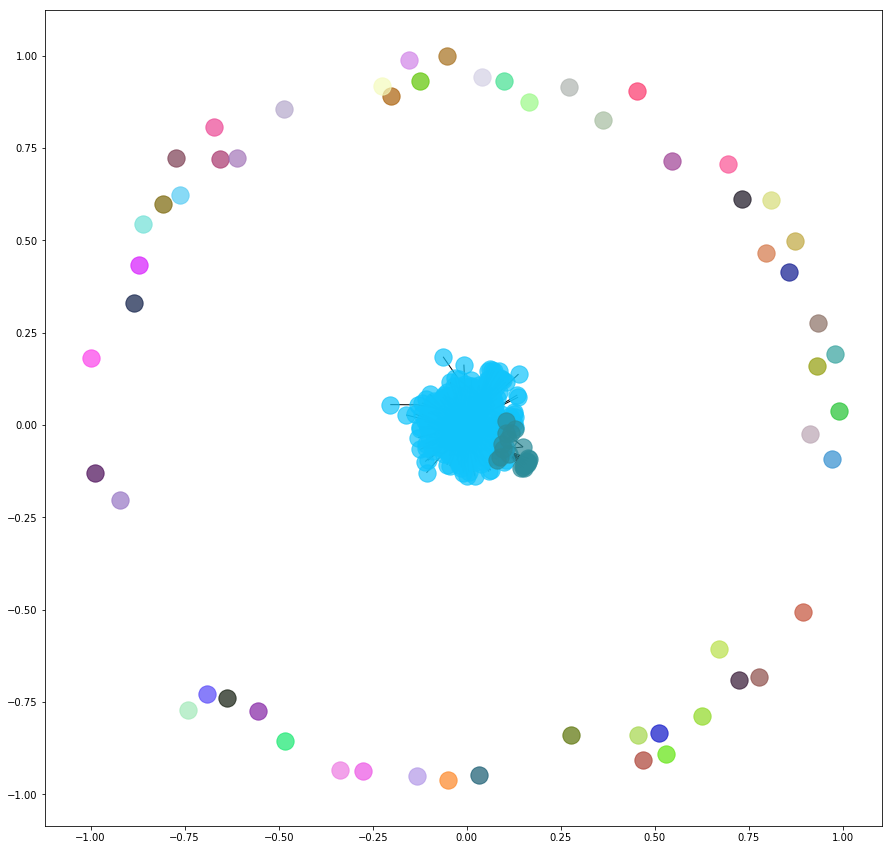

In [158]:
from matplotlib.pyplot import figure
import numpy

figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for community in list(communities_gn):
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=community,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.show()

In [159]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
communities_gmc = greedy_modularity_communities(G_sampled)

communities_sum = 0

for community_gmc in communities_gmc:
    communities_sum += 1
    print("Community ", communities_sum)
    print(community_gmc)
    print("Liczność community: ", len(community_gmc), "\n")
    
print("Znaleziono communities: ", communities_sum)

Community  1
frozenset({'∂(Megan)/∂(t)🇺🇸', 'Greg', 'Lana', 'Sheriff Paul Babeu', 'Sarah Ruth Ashcraft', 'Deplorable FOR TRUMP', 'Azadeh Shahshahani', 'LydiaL', 'james cabbage', 'Kathy', 'Tim Donnelly for Congress', 'The Tweetwit', 'Jamie Ford', 'Alisha VOTED💃🏽🌊', 'Matty Enders #MAGA Veteran', 'Thomas P Kennedy III 🇺🇸', '❌🇺🇸I AM NOBODY🇺🇸❌', 'Michael', 'Christopher Crossley', 'Kevin M. Levin', 'Tony Stark 2018 💥', 'Silvia', 'John Seeliger 🌊🌊🌊 #TeamBeto #TeamBlueTsunami', 'Vote November 6th', 'Mike', 'ThinGrayLine 🐻', 'Элизабет, i mean “elisabeth”', 'A.Silver-MeMEs & GIFs', 'Jan', 'iMissBarack&Michelle🆗', 'Jzh', 'Thomas', 'Amy Kremer', 'Ed Krassenstein', 'MD DD', 'Jen ❤ 🇺🇸', 'Bill Spadea', 'Jaci Huffman', 'RiotGrl✨', 'Tara McCarthy', 'Doug & Karla', 'Charlotte Clymer🏳️\u200d🌈', 'Puppet String News', 'Anita', 'Anthony', '❌Red Belair❌', 'HLN', 'Barbara', 'Karen', 'TheKat ❤️', '#VOP - Stop Child Trafficking', "It's all going to be OK👌 ن", 'Adrian Norman', 'DuncanEsq ✝️🇺🇸⚖️⭐️⭐️⭐️', 'Paul', 'T

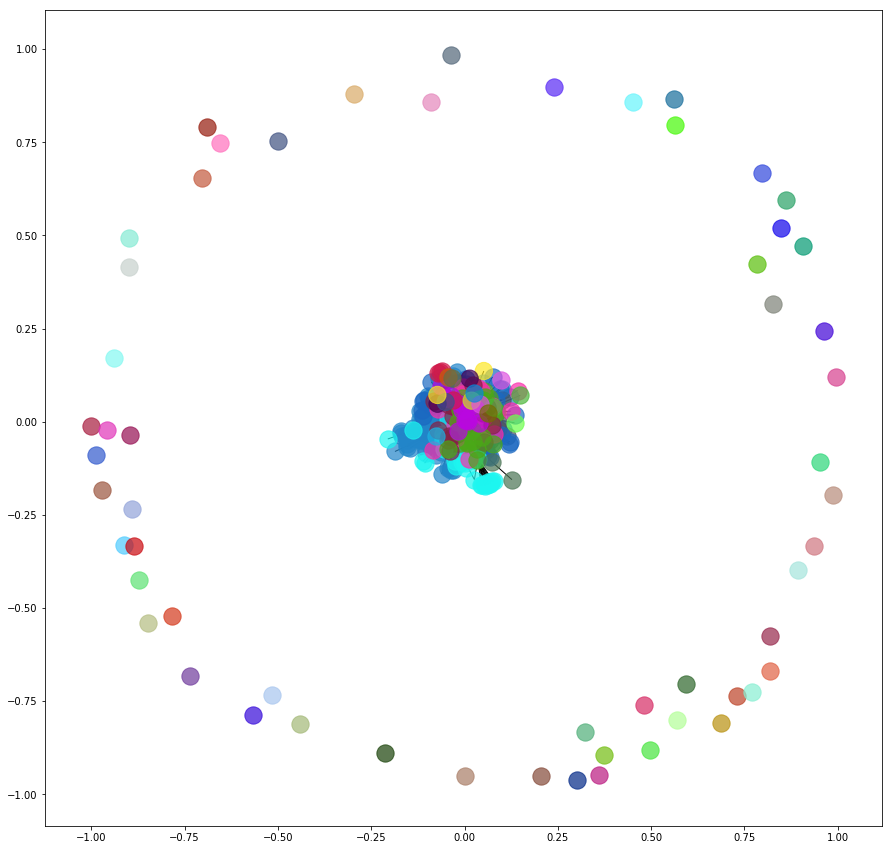

In [160]:
figure(figsize=(15,15))
pos = nx.spring_layout(G_sampled)
for community in communities_gmc:
    nx.draw_networkx_nodes(G_sampled, pos=pos,
                           nodelist=community,
                           node_color=numpy.random.rand(3,),
                           alpha=0.7)
nx.draw_networkx_edges(G_sampled, pos=pos, edgelist=G_sampled.edges)

plt.show()

In [161]:
sorted(G_sampled.degree, key=lambda x: x[1], reverse=True)[:10]


[('Patriot Gary', 357),
 ('TheKat ❤️', 283),
 ('Cody', 261),
 ('Chris  🇺🇸 Let Freedom Ring', 171),
 ('#ThePersistence', 150),
 ('Jennifer 🔱🇺🇸🔱🌟🌟🌟', 149),
 ('🇺🇸🔥Lady De’Plorable🔥🇺🇸', 149),
 ('Black🕷Widow', 145),
 ('🦅 🦅 Nationalist Eagle 🦅🦅', 143),
 ('ɳαɳ૮ყ ن💄#VOTERed', 143)]